In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd
from datetime import timedelta

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])

In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Index')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Index')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

# Function to convert HHMMSS to seconds
def time_to_seconds(time_str):
    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    return hours * 3600 + minutes * 60 + seconds

def time_to_secondsdf(time_value):
    return time_value.hour * 3600 + time_value.minute * 60 + time_value.second + time_value.microsecond / 1e6

# Function to extract the timestamp part from the file path
def extract_timestamp(file_path):
    # Extract the filename from the file path
    filename = os.path.basename(file_path)
    # Split the filename and extract the time part (second item after '-')
    timestamp_part = filename.split('-')[1]  # Extracting the 'HHMMSS' part
    return timestamp_part

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    initialtime = time_to_seconds(extract_timestamp(file_list[0]))
    timeelapsed = []

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        currenttime = time_to_seconds(extract_timestamp(file_list[x]))
        timepassed = currenttime - initialtime
        timeelapsed.append(timepassed)
        
        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return pos, mags, locpred, anglepred, Bstdev, timeelapsed

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [3]:
folder = os.path.join('..', './MLX09092024_GammaKnife1')
pos, mags, locpred, anglepred, Bstdev, timeelapsed = importfitting(folder)
np.append(locpred, anglepred, axis=1)

['..\\./MLX09092024_GammaKnife1\\20240909-001335-813367.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001348-029688.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001402-597941.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001412-208585.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001607-316058.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001651-572258.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001717-822760.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001759-519030.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001920-910510.npz', '..\\./MLX09092024_GammaKnife1\\20240909-001959-939043.npz', '..\\./MLX09092024_GammaKnife1\\20240909-002023-334893.npz', '..\\./MLX09092024_GammaKnife1\\20240909-002103-954153.npz', '..\\./MLX09092024_GammaKnife1\\20240909-002213-317930.npz', '..\\./MLX09092024_GammaKnife1\\20240909-002318-539408.npz', '..\\./MLX09092024_GammaKnife1\\20240909-002348-090183.npz', '..\\./MLX09092024_GammaKnife1\\20240909-002439-289058.npz']


array([[ 3.15068706e+00,  1.82475970e+00,  2.98210999e+01,
         4.60329119e-01,  1.11202097e-01, -8.85842875e-01],
       [ 6.60026464e+00,  3.59083904e+00,  3.02003078e+01,
         1.74266066e-01, -7.84891684e-02, -1.00000000e+00],
       [ 8.54010555e+00,  4.82707932e+00,  3.12400792e+01,
         2.31429896e-01, -4.23611184e-02, -9.72714292e-01],
       [ 6.70615565e+00,  2.67570025e+00,  3.13230083e+01,
         3.65114227e-01,  1.33744242e-01, -9.21398490e-01],
       [ 2.46165818e+00,  6.61683163e-01,  2.93485205e+01,
         5.03109224e-01,  1.30836847e-01, -8.54261605e-01],
       [ 2.59497978e+00,  6.47005266e-01,  2.93577097e+01,
         4.95154664e-01,  1.34444150e-01, -8.58339461e-01],
       [ 1.90571551e+00,  2.63718101e+00,  2.85306726e+01,
         3.48783664e-01, -3.59659299e-02, -9.36817694e-01],
       [-1.27685745e-01,  1.65277204e+00,  2.81758633e+01,
         5.18312616e-01,  5.41033343e-02, -8.53822570e-01],
       [ 3.37023017e+00, -1.96644115e+00,  2.849

In [4]:
print(anglepred[:,2])

[-0.88584287 -1.         -0.97271429 -0.92139849 -0.85426161 -0.85833946
 -0.93681769 -0.85382257 -0.87916161 -0.87143167 -0.8682575  -0.86935289
 -0.43517675 -0.09997316 -0.03436474 -0.03236186]


In [5]:
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

all_mags = [np.array([0,0,0])]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    all_mags = np.append(all_mags, mags[0], axis=0)
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
all_mags = np.delete(all_mags, 0, axis=0)

print(all_mags)
bx = all_mags[:,0]
by = all_mags[:,1]
bz = all_mags[:,2]

print(bx)
len(bx)

[[-0.0657   -0.1734   -0.351384]
 [-0.1236   -0.165    -0.325248]
 [-0.1761   -0.2049   -0.253616]
 [-0.2175   -0.1074   -0.175208]
 [-0.0372   -0.1101   -0.406076]
 [-0.1266   -0.0999   -0.39446 ]
 [-0.1926   -0.1407   -0.322344]
 [-0.2268   -0.072    -0.22506 ]
 [-0.0345   -0.003    -0.449152]
 [-0.1539   -0.0423   -0.41382 ]
 [-0.2025    0.0048   -0.34606 ]
 [-0.2415   -0.0297   -0.226028]
 [-0.0324    0.081    -0.422048]
 [-0.1389    0.1014   -0.428824]
 [-0.2148    0.0675   -0.357192]
 [-0.2268    0.0651   -0.254584]
 [-0.0645   -0.1743   -0.354288]
 [-0.1215   -0.1662   -0.3267  ]
 [-0.1755   -0.204    -0.256036]
 [-0.2184   -0.1083   -0.174724]
 [-0.0384   -0.1098   -0.404624]
 [-0.1245   -0.0996   -0.39204 ]
 [-0.1923   -0.1413   -0.32186 ]
 [-0.2262   -0.0723   -0.22506 ]
 [-0.0315   -0.003    -0.453024]
 [-0.1536   -0.0441   -0.4114  ]
 [-0.2022    0.0057   -0.345576]
 [-0.2415   -0.0318   -0.22506 ]
 [-0.0318    0.0837   -0.422532]
 [-0.1374    0.102    -0.429308]
 [-0.2145 

256

In [6]:
bx7 = []
by7 = []
bz7 = []
for x in range(len(bx)):
    if x % 16 == 6:
        bx7.append(bx[x])
        by7.append(by[x])
        bz7.append(bz[x])
print(bx7)
print(pos)

[-0.1926, -0.19229999999999997, -0.1809, -0.18, -0.2052, -0.2046, -0.189, -0.1899, -0.2418, -0.2418, -0.0732, -0.0726, -0.13290000000000002, -0.13290000000000002, -0.1113, -0.11159999999999999]
[[ 6.75 -6.75  0.  ]
 [ 2.25 -6.75  0.  ]
 [-2.25 -6.75  0.  ]
 [-6.75 -6.75  0.  ]
 [ 6.75 -2.25  0.  ]
 [ 2.25 -2.25  0.  ]
 [-2.25 -2.25  0.  ]
 [-6.75 -2.25  0.  ]
 [ 6.75  2.25  0.  ]
 [ 2.25  2.25  0.  ]
 [-2.25  2.25  0.  ]
 [-6.75  2.25  0.  ]
 [ 6.75  6.75  0.  ]
 [ 2.25  6.75  0.  ]
 [-2.25  6.75  0.  ]
 [-6.75  6.75  0.  ]]


In [7]:
index = np.array(range(len(bx7)))
measuredbx = go.Scatter(x=index, y=bx7, mode='markers')
layoutbx = go.Layout(title='b_x over time')
figbx = go.Figure(data=[measuredbx], layout=layoutbx)
figbx.update_yaxes(scaleanchor='y')
figbx.update_layout(
    xaxis_title="Index",
    yaxis_title="b_x [mT]"
)
figbx.show()

In [8]:
measuredby = go.Scatter(x=index, y=by7, mode='markers')
layoutby = go.Layout(title='b_y over time')
figby = go.Figure(data=[measuredby], layout=layoutby)
figby.update_yaxes(scaleanchor='y')
figby.update_layout(
    xaxis_title="Index",
    yaxis_title="b_y [mT]"
)
figby.show()

In [9]:
measuredbz = go.Scatter(x=index, y=bz7, mode='markers')
layoutbz = go.Layout(title='b_z over time')
figbz = go.Figure(data=[measuredbz], layout=layoutbz)
figbz.update_yaxes(scaleanchor='y')
figbz.update_layout(
    xaxis_title="Index",
    yaxis_title="b_z [mT]"
)
figbz.show()

In [10]:
# Specify the Excel file name (replace with your actual file name)
file = 'Shift_data_09092024.txt'

# Create the full file path
file_path = os.path.join('..', file)

# Read the Excel file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=',', na_values="        NaN")

df.dropna(inplace=True)
df[['X', 'Y', 'Z', 'Displacement [mm]']] = df[['X', 'Y', 'Z', 'Displacement [mm]']].apply(pd.to_numeric,errors='coerce')
df['No.'] = pd.to_datetime(df['No.'], format='%Y-%m-%dT%H:%M:%S.%f')
df['datetime'] = df.loc[0:,'No.'].dt.time


print(df)
hdmm_time = df['datetime'].apply(time_to_secondsdf)
hdmm_disp = df.loc[0:,'Displacement [mm]']
hdmm_x = df.loc[0:, 'X']
hdmm_y = df.loc[0:, 'Y']
hdmm_z = df.loc[0:, 'Z']
print(hdmm_time)

                         No.     X     Y     Z  Displacement [mm]  \
4    2024-09-09 17:13:56.101 -0.01 -0.00 -0.01               0.02   
5    2024-09-09 17:13:56.599 -0.01  0.00  0.01               0.02   
6    2024-09-09 17:13:57.115 -0.00 -0.01 -0.01               0.01   
7    2024-09-09 17:13:57.633  0.06 -0.01 -0.01               0.06   
8    2024-09-09 17:13:58.182  0.02 -0.01 -0.05               0.05   
...                      ...   ...   ...   ...                ...   
5238 2024-09-09 18:00:38.645  0.01 -0.01 -0.02               0.02   
5239 2024-09-09 18:00:39.161  0.01 -0.02 -0.05               0.06   
5240 2024-09-09 18:00:39.678  0.02 -0.05 -0.08               0.10   
5241 2024-09-09 18:00:40.242  0.02 -0.03 -0.06               0.07   
5242 2024-09-09 18:00:40.742  0.01 -0.01 -0.05               0.05   

             datetime  
4     17:13:56.101000  
5     17:13:56.599000  
6     17:13:57.115000  
7     17:13:57.633000  
8     17:13:58.182000  
...               ...  
523

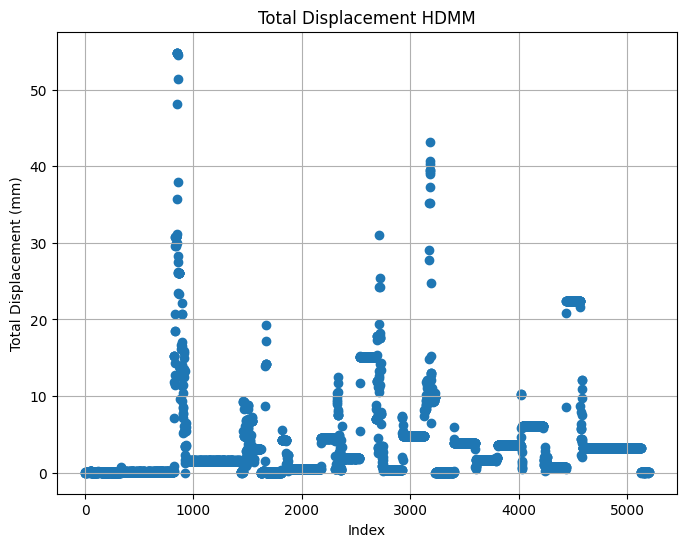

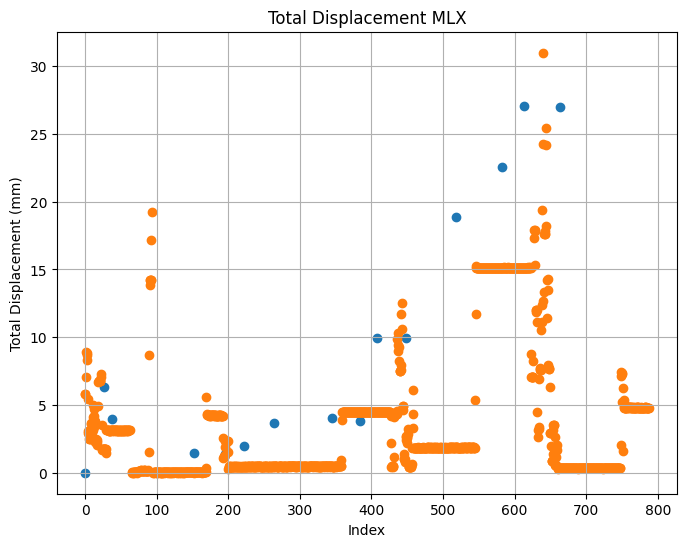

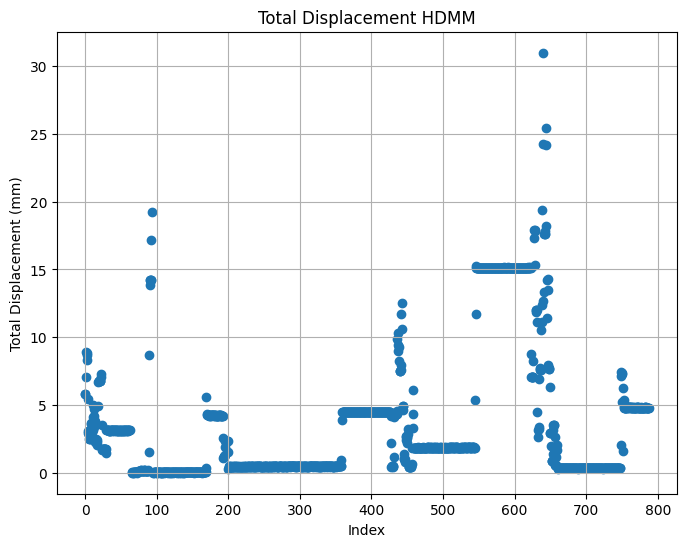

In [11]:
rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)


a = 1500
b = 3000
c = 1524

hdmm_disp2 = hdmm_disp[a:b]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_disp))), hdmm_disp)
plt.xlabel('Index')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timeelapsed, disp)
plt.scatter(hdmm_time[a:b]-hdmm_time[c], hdmm_disp2)
plt.xlabel('Index')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement MLX')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(hdmm_time[a:b]-hdmm_time[c], hdmm_disp2)
plt.xlabel('Index')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement HDMM')
plt.grid(True)
plt.show()

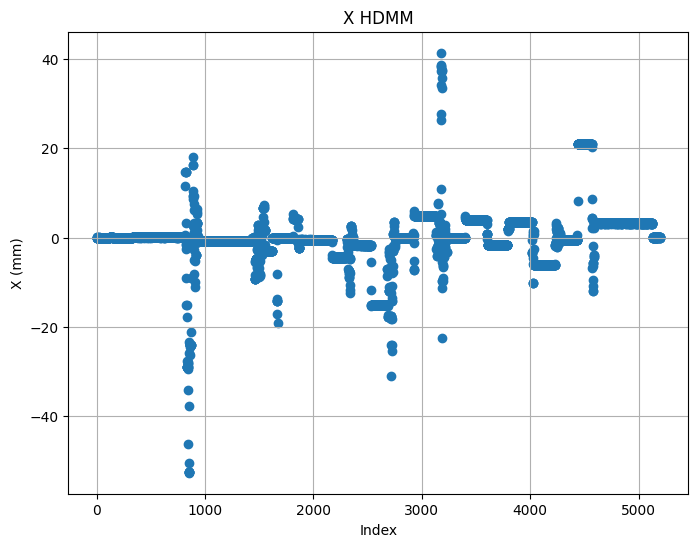

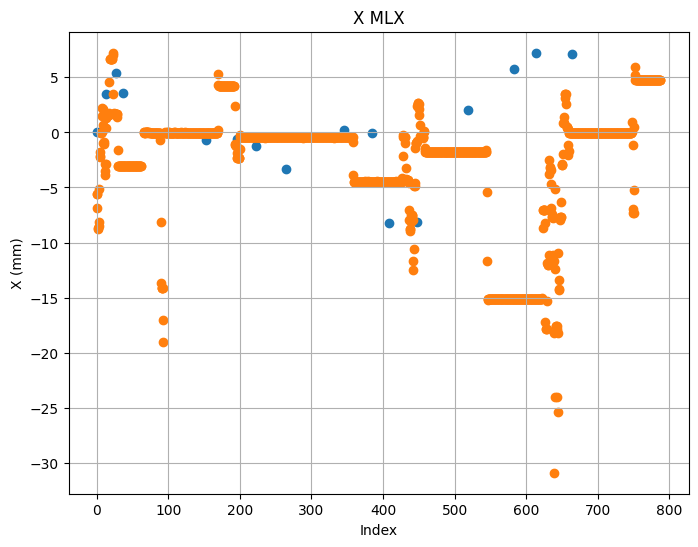

In [12]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_x))), hdmm_x)
plt.xlabel('Index')
plt.ylabel('X (mm)')
plt.title('X HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timeelapsed, rel_loc_predx)
plt.scatter(hdmm_time[a:b]-hdmm_time[c], hdmm_x[a:b])
plt.xlabel('Index')
plt.ylabel('X (mm)')
plt.title('X MLX')
plt.grid(True)
plt.show()

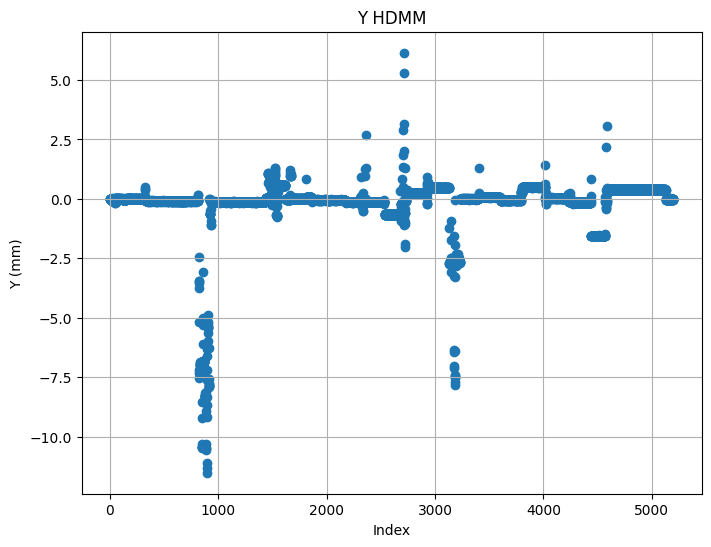

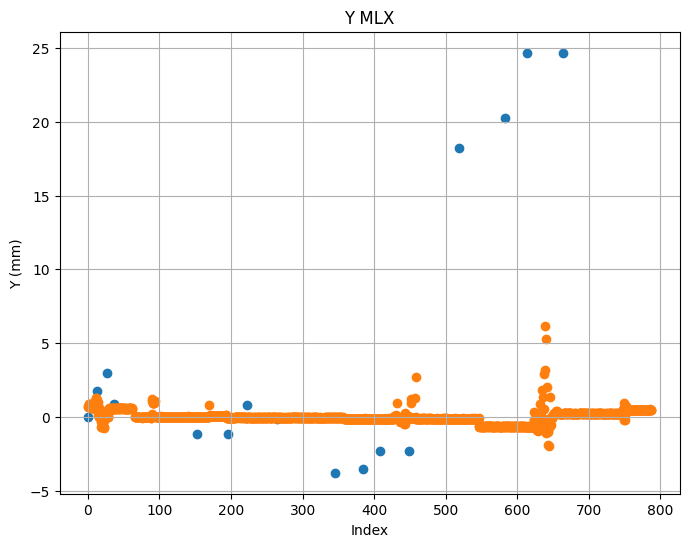

In [13]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_y))), hdmm_y)
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timeelapsed, rel_loc_predy)
plt.scatter(hdmm_time[a:b]-hdmm_time[c], hdmm_y[a:b])
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y MLX')
plt.grid(True)
plt.show()

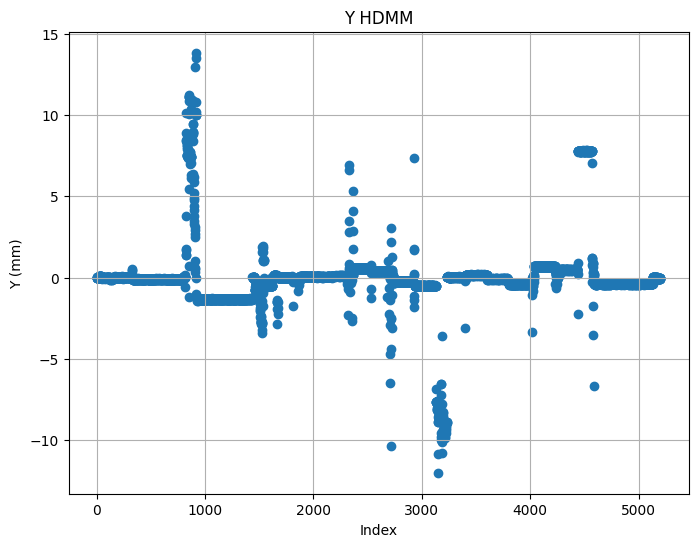

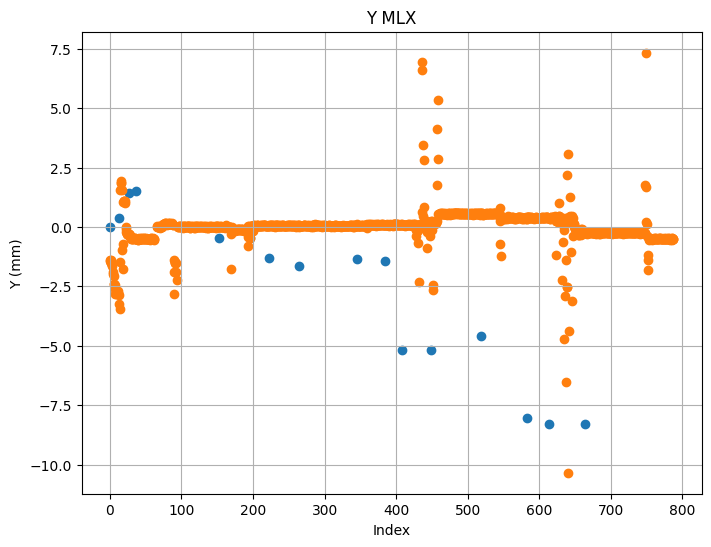

In [14]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(hdmm_z))), hdmm_z)
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y HDMM')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timeelapsed, rel_loc_predz)
plt.scatter(hdmm_time[a:b]-hdmm_time[c], hdmm_z[a:b])
plt.xlabel('Index')
plt.ylabel('Y (mm)')
plt.title('Y MLX')
plt.grid(True)
plt.show()